# PreTrain

In [1]:
from model.sswae_dev2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params, calculate_sharpness
from XAE.sampler import gaus
from XAE.logging_daily import logging_daily
import XAE.fid as fid
from random import sample

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 6

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 25
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.429
[2] loss: 0.321
[3] loss: 0.148
[4] loss: 0.087
[5] loss: 0.055
[6] loss: 0.036
[7] loss: 0.027
[8] loss: 0.020
[9] loss: 0.016
[10] loss: 0.010
[11] loss: 0.010
[12] loss: 0.007
[13] loss: 0.009
[14] loss: 0.010
[15] loss: 0.004
[16] loss: 0.004
[17] loss: 0.004
[18] loss: 0.006
[19] loss: 0.003
[20] loss: 0.005
[21] loss: 0.003
[22] loss: 0.004
[23] loss: 0.003
[24] loss: 0.002
[25] loss: 0.001


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 6])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

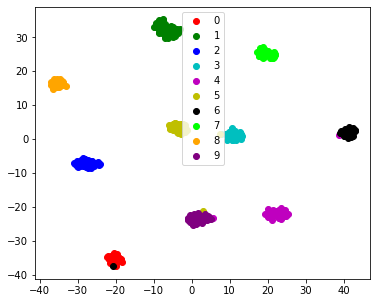

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

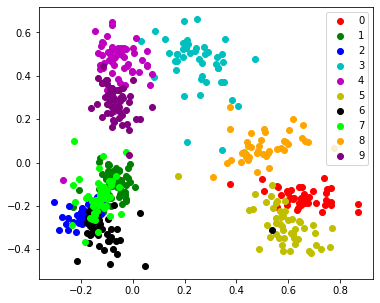

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()

In [12]:
w = torch.Tensor(ys.transpose()/cs)
w

tensor([[ 0.6388, -0.0884, -0.1751,  0.2192, -0.0721,  0.5494, -0.1125, -0.1360,
          0.4976, -0.0826],
        [ 0.4453, -0.2081, -0.2839, -0.2304,  0.3685, -0.2509,  0.4192,  0.2891,
         -0.1840,  0.0563],
        [-0.1559, -0.1149, -0.2394,  0.4675,  0.4893, -0.2990, -0.2868, -0.1726,
          0.0629,  0.2949],
        [-0.1600,  0.4189, -0.2122, -0.1213,  0.1041, -0.1560, -0.1763,  0.5876,
          0.4729, -0.1803],
        [-0.2443, -0.1407, -0.2515,  0.0750, -0.2842,  0.5653,  0.1895,  0.2706,
         -0.1153,  0.6270],
        [-0.1432,  0.4275, -0.2384,  0.3786, -0.1260, -0.0107,  0.4784, -0.2148,
         -0.2461, -0.1733]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w
torch.save(f1.state_dict(), f'./result/f1_{y_dim}.pt')

# Train

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_4.cfg')

['./config/sswae_dev2_4.cfg']

In [4]:
mm = cur_model(cfg, log, device = device)
mm.f1.load_state_dict(torch.load(f'./result/mu_{y_dim}.pt'))
mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 6
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 6
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [001/100]  loss: 2.346125e-01  D: 6.914759e-01  D2: 4.437131e-02  D3: 2.342034e-03
test loss: 1.732662e-01  D: 6.933237e-01  D2: 1.625302e-02  D3: 7.270615e-03


[default |INFO|model.py:1280] [002/100]  loss: 1.608556e-01  D: 6.936119e-01  D2: 7.879914e-03  D3: 9.259275e-03
test loss: 1.467174e-01  D: 6.702496e-01  D2: 3.072977e-03  D3: 1.223031e-02


[default |INFO|model.py:1280] [003/100]  loss: 1.434466e-01  D: 6.946424e-01  D2: 2.191931e-03  D3: 1.135255e-02
test loss: 1.301684e-01  D: 6.998821e-01  D2: 3.094101e-04  D3: 1.261800e-02


[default |INFO|model.py:1280] [004/100]  loss: 1.103005e-01  D: 6.968650e-01  D2: -1.636381e-03  D3: 9.595568e-03
test loss: 1.133600e-01  D: 6.606068e-01  D2: -2.987585e-03  D3: 1.434403e-02


[default |INFO|model.py:1280] [005/100]  loss: 1.040569e-01  D: 6.941008e-01  D2: -2.139529e-03  D3: 1.614304e-02
test loss: 9.329535e-02  D: 6.978290e-01  D2: -1.134253e-03  D3: 1.595521e-02


[default |INFO|model.py:1280] [006/100]  loss: 9.263417e-02  D: 6.935074e-01  D2: -2.999582e-03  D3: 1.569510e-02
test loss: 8.360433e-02  D: 7.049264e-01  D2: -4.613628e-03  D3: 1.514995e-02


[default |INFO|model.py:1280] [007/100]  loss: 8.166466e-02  D: 6.937692e-01  D2: -3.905711e-03  D3: 1.549128e-02
test loss: 7.774555e-02  D: 6.958612e-01  D2: -4.899073e-03  D3: 1.493538e-02


[default |INFO|model.py:1280] [008/100]  loss: 7.834050e-02  D: 6.951476e-01  D2: -4.604007e-03  D3: 1.415477e-02
test loss: 7.471751e-02  D: 6.946173e-01  D2: -4.436045e-03  D3: 1.418829e-02


[default |INFO|model.py:1280] [009/100]  loss: 7.453204e-02  D: 6.934465e-01  D2: -4.828518e-03  D3: 1.501775e-02
test loss: 7.059958e-02  D: 7.007896e-01  D2: -4.989243e-03  D3: 1.392788e-02


[default |INFO|model.py:1280] [010/100]  loss: 7.127073e-02  D: 6.944083e-01  D2: -4.692671e-03  D3: 1.497969e-02
test loss: 6.776555e-02  D: 6.922711e-01  D2: -5.498171e-03  D3: 1.208857e-02


[default |INFO|model.py:1280] [011/100]  loss: 6.974414e-02  D: 6.943616e-01  D2: -5.058761e-03  D3: 1.467668e-02
test loss: 6.624253e-02  D: 6.994594e-01  D2: -5.584717e-03  D3: 1.297960e-02


[default |INFO|model.py:1280] [012/100]  loss: 6.665136e-02  D: 6.937418e-01  D2: -5.178127e-03  D3: 1.478698e-02
test loss: 6.625159e-02  D: 7.058306e-01  D2: -5.949059e-03  D3: 1.500654e-02


[default |INFO|model.py:1280] [013/100]  loss: 6.505497e-02  D: 6.945735e-01  D2: -5.401341e-03  D3: 1.438346e-02
test loss: 6.524320e-02  D: 6.944876e-01  D2: -5.552216e-03  D3: 1.247153e-02


[default |INFO|model.py:1280] [014/100]  loss: 6.437224e-02  D: 6.940435e-01  D2: -5.483878e-03  D3: 1.446022e-02
test loss: 6.335519e-02  D: 6.858877e-01  D2: -5.903416e-03  D3: 1.553169e-02


[default |INFO|model.py:1280] [015/100]  loss: 6.187674e-02  D: 6.926813e-01  D2: -5.776900e-03  D3: 1.464591e-02
test loss: 6.079771e-02  D: 7.066781e-01  D2: -5.997839e-03  D3: 1.413711e-02


[default |INFO|model.py:1280] [016/100]  loss: 6.078150e-02  D: 6.943515e-01  D2: -6.052361e-03  D3: 1.417300e-02
test loss: 6.195158e-02  D: 6.734516e-01  D2: -5.476151e-03  D3: 1.433992e-02


[default |INFO|model.py:1280] [017/100]  loss: 5.961338e-02  D: 6.936250e-01  D2: -6.043277e-03  D3: 1.431731e-02
test loss: 5.952690e-02  D: 6.767175e-01  D2: -6.687508e-03  D3: 1.414020e-02


[default |INFO|model.py:1280] [018/100]  loss: 5.891308e-02  D: 6.938254e-01  D2: -6.246680e-03  D3: 1.447231e-02
test loss: 5.894683e-02  D: 6.782213e-01  D2: -6.903181e-03  D3: 1.543451e-02


[default |INFO|model.py:1280] [019/100]  loss: 5.843241e-02  D: 6.932488e-01  D2: -6.263630e-03  D3: 1.435831e-02
test loss: 5.882991e-02  D: 6.916848e-01  D2: -7.110109e-03  D3: 1.383334e-02


[default |INFO|model.py:1280] [020/100]  loss: 5.793803e-02  D: 6.936870e-01  D2: -6.780516e-03  D3: 1.383580e-02
test loss: 5.797224e-02  D: 6.851739e-01  D2: -6.300297e-03  D3: 1.212299e-02


[default |INFO|model.py:1280] [021/100]  loss: 5.812566e-02  D: 6.935049e-01  D2: -6.937254e-03  D3: 1.378565e-02
test loss: 5.968387e-02  D: 7.058341e-01  D2: -6.251736e-03  D3: 1.423086e-02


[default |INFO|model.py:1280] [022/100]  loss: 5.687987e-02  D: 6.942718e-01  D2: -7.064214e-03  D3: 1.393219e-02
test loss: 5.663596e-02  D: 6.895054e-01  D2: -7.523994e-03  D3: 1.378717e-02


[default |INFO|model.py:1280] [023/100]  loss: 5.626208e-02  D: 6.935072e-01  D2: -7.242448e-03  D3: 1.353289e-02
test loss: 5.592101e-02  D: 6.853724e-01  D2: -7.590723e-03  D3: 1.334584e-02


[default |INFO|model.py:1280] [024/100]  loss: 5.501760e-02  D: 6.937654e-01  D2: -7.337844e-03  D3: 1.392870e-02
test loss: 5.564512e-02  D: 6.889254e-01  D2: -7.516985e-03  D3: 1.364087e-02


[default |INFO|model.py:1280] [025/100]  loss: 5.496865e-02  D: 6.933668e-01  D2: -7.629112e-03  D3: 1.381279e-02
test loss: 5.637560e-02  D: 6.972307e-01  D2: -8.048515e-03  D3: 1.165074e-02


[default |INFO|model.py:1280] [026/100]  loss: 5.717023e-02  D: 6.942299e-01  D2: -7.731953e-03  D3: 1.335968e-02
test loss: 5.757741e-02  D: 6.955168e-01  D2: -8.043213e-03  D3: 1.152339e-02


[default |INFO|model.py:1280] [027/100]  loss: 5.633623e-02  D: 6.939528e-01  D2: -7.761594e-03  D3: 1.313736e-02
test loss: 5.560650e-02  D: 6.686064e-01  D2: -7.597990e-03  D3: 1.278773e-02


[default |INFO|model.py:1280] [028/100]  loss: 5.533536e-02  D: 6.937217e-01  D2: -8.051194e-03  D3: 1.345333e-02
test loss: 5.662664e-02  D: 6.957899e-01  D2: -8.006802e-03  D3: 1.517474e-02


[default |INFO|model.py:1280] [029/100]  loss: 5.473601e-02  D: 6.934255e-01  D2: -8.191535e-03  D3: 1.346747e-02
test loss: 5.630413e-02  D: 6.833286e-01  D2: -8.257704e-03  D3: 1.247579e-02


[default |INFO|model.py:1280] [030/100]  loss: 5.415251e-02  D: 6.933016e-01  D2: -8.255483e-03  D3: 1.333966e-02
test loss: 5.525216e-02  D: 6.942476e-01  D2: -8.782864e-03  D3: 1.225805e-02


[default |INFO|model.py:1280] [031/100]  loss: 5.422779e-02  D: 6.942040e-01  D2: -8.373849e-03  D3: 1.344429e-02
test loss: 5.707024e-02  D: 7.037321e-01  D2: -8.304386e-03  D3: 1.482888e-02


[default |INFO|model.py:1280] [032/100]  loss: 5.345752e-02  D: 6.934442e-01  D2: -8.587343e-03  D3: 1.331104e-02
test loss: 5.790680e-02  D: 6.821937e-01  D2: -8.241529e-03  D3: 1.288281e-02


[default |INFO|model.py:1280] [033/100]  loss: 5.395702e-02  D: 6.931331e-01  D2: -8.552003e-03  D3: 1.323123e-02
test loss: 5.780810e-02  D: 7.005953e-01  D2: -8.790293e-03  D3: 1.111099e-02


[default |INFO|model.py:1280] [034/100]  loss: 5.347674e-02  D: 6.938921e-01  D2: -8.856589e-03  D3: 1.323661e-02
test loss: 5.505325e-02  D: 6.821559e-01  D2: -8.752747e-03  D3: 1.343146e-02


[default |INFO|model.py:1280] [035/100]  loss: 5.228238e-02  D: 6.930881e-01  D2: -8.905414e-03  D3: 1.313816e-02
test loss: 5.290184e-02  D: 6.991500e-01  D2: -8.854837e-03  D3: 1.248797e-02


[default |INFO|model.py:1280] [036/100]  loss: 5.172850e-02  D: 6.932939e-01  D2: -9.009156e-03  D3: 1.314740e-02
test loss: 5.242894e-02  D: 6.856279e-01  D2: -8.745041e-03  D3: 1.229994e-02


[default |INFO|model.py:1280] [037/100]  loss: 5.226386e-02  D: 6.933667e-01  D2: -9.108175e-03  D3: 1.286869e-02
test loss: 5.508915e-02  D: 6.885925e-01  D2: -9.295549e-03  D3: 1.164516e-02


[default |INFO|model.py:1280] [038/100]  loss: 5.191244e-02  D: 6.936076e-01  D2: -9.162733e-03  D3: 1.292846e-02
test loss: 5.215026e-02  D: 6.924099e-01  D2: -9.457970e-03  D3: 1.342576e-02


[default |INFO|model.py:1280] [039/100]  loss: 5.276861e-02  D: 6.941253e-01  D2: -9.234543e-03  D3: 1.250326e-02
test loss: 5.475945e-02  D: 6.750675e-01  D2: -9.415627e-03  D3: 1.092007e-02


[default |INFO|model.py:1280] [040/100]  loss: 5.284065e-02  D: 6.937382e-01  D2: -9.285305e-03  D3: 1.296946e-02
test loss: 5.234972e-02  D: 6.860987e-01  D2: -9.510660e-03  D3: 1.383513e-02


[default |INFO|model.py:1280] [041/100]  loss: 5.127679e-02  D: 6.936672e-01  D2: -9.254889e-03  D3: 1.300415e-02
test loss: 5.266828e-02  D: 7.032440e-01  D2: -9.585247e-03  D3: 1.171674e-02


[default |INFO|model.py:1280] [042/100]  loss: 5.128143e-02  D: 6.934059e-01  D2: -9.446707e-03  D3: 1.283522e-02
test loss: 5.344242e-02  D: 6.951175e-01  D2: -9.516811e-03  D3: 1.397749e-02


[default |INFO|model.py:1280] [043/100]  loss: 5.056095e-02  D: 6.926238e-01  D2: -9.561448e-03  D3: 1.310536e-02
test loss: 5.312062e-02  D: 6.939410e-01  D2: -9.323387e-03  D3: 1.272877e-02


[default |INFO|model.py:1280] [044/100]  loss: 5.074063e-02  D: 6.938840e-01  D2: -9.515718e-03  D3: 1.284656e-02
test loss: 5.507253e-02  D: 6.970339e-01  D2: -1.004678e-02  D3: 1.346508e-02


[default |INFO|model.py:1280] [045/100]  loss: 5.111783e-02  D: 6.932524e-01  D2: -9.561860e-03  D3: 1.296209e-02
test loss: 5.162067e-02  D: 7.005699e-01  D2: -9.587755e-03  D3: 1.301109e-02


[default |INFO|model.py:1280] [046/100]  loss: 5.014821e-02  D: 6.935462e-01  D2: -9.643200e-03  D3: 1.280840e-02
test loss: 5.307257e-02  D: 7.095982e-01  D2: -9.579649e-03  D3: 1.233764e-02


[default |INFO|model.py:1280] [047/100]  loss: 5.019810e-02  D: 6.938615e-01  D2: -9.785797e-03  D3: 1.264272e-02
test loss: 5.204718e-02  D: 6.827133e-01  D2: -9.894924e-03  D3: 1.223488e-02


[default |INFO|model.py:1280] [048/100]  loss: 5.056339e-02  D: 6.938865e-01  D2: -9.768922e-03  D3: 1.254723e-02
test loss: 5.124656e-02  D: 6.953286e-01  D2: -9.826031e-03  D3: 1.193209e-02


[default |INFO|model.py:1280] [049/100]  loss: 5.035716e-02  D: 6.930185e-01  D2: -9.634967e-03  D3: 1.283874e-02
test loss: 5.359576e-02  D: 7.045656e-01  D2: -9.725447e-03  D3: 1.126006e-02


[default |INFO|model.py:1280] [050/100]  loss: 4.987796e-02  D: 6.932253e-01  D2: -9.732170e-03  D3: 1.253969e-02
test loss: 5.229589e-02  D: 6.900546e-01  D2: -9.705963e-03  D3: 1.285209e-02


[default |INFO|model.py:1280] [051/100]  loss: 4.921572e-02  D: 6.935282e-01  D2: -9.859420e-03  D3: 1.269600e-02
test loss: 5.061879e-02  D: 6.906021e-01  D2: -9.784212e-03  D3: 1.135454e-02


[default |INFO|model.py:1280] [052/100]  loss: 4.890337e-02  D: 6.929036e-01  D2: -9.757160e-03  D3: 1.269021e-02
test loss: 4.986084e-02  D: 6.947669e-01  D2: -1.009357e-02  D3: 1.302181e-02


[default |INFO|model.py:1280] [053/100]  loss: 4.866561e-02  D: 6.930070e-01  D2: -9.879204e-03  D3: 1.252426e-02
test loss: 5.134145e-02  D: 6.895570e-01  D2: -1.005651e-02  D3: 1.127487e-02


[default |INFO|model.py:1280] [054/100]  loss: 4.925727e-02  D: 6.938402e-01  D2: -9.942249e-03  D3: 1.249824e-02
test loss: 5.175243e-02  D: 6.873551e-01  D2: -9.990788e-03  D3: 1.093894e-02


[default |INFO|model.py:1280] [055/100]  loss: 4.999714e-02  D: 6.914531e-01  D2: -9.846079e-03  D3: 1.236873e-02
test loss: 5.428028e-02  D: 6.884794e-01  D2: -9.808655e-03  D3: 1.071929e-02


[default |INFO|model.py:1280] [056/100]  loss: 5.032813e-02  D: 6.928255e-01  D2: -9.929447e-03  D3: 1.198027e-02
test loss: 5.155624e-02  D: 6.965953e-01  D2: -1.023650e-02  D3: 1.196442e-02


[default |INFO|model.py:1280] [057/100]  loss: 4.932147e-02  D: 6.953165e-01  D2: -9.922568e-03  D3: 1.231424e-02
test loss: 5.129796e-02  D: 7.048405e-01  D2: -1.028404e-02  D3: 1.310030e-02


[default |INFO|model.py:1280] [058/100]  loss: 4.908334e-02  D: 6.925508e-01  D2: -1.001160e-02  D3: 1.248505e-02
test loss: 4.940524e-02  D: 7.047163e-01  D2: -9.954214e-03  D3: 1.258488e-02


[default |INFO|model.py:1280] [059/100]  loss: 4.946881e-02  D: 6.940435e-01  D2: -9.994362e-03  D3: 1.212511e-02
test loss: 5.223192e-02  D: 6.938553e-01  D2: -9.404745e-03  D3: 1.252450e-02


[default |INFO|model.py:1280] [060/100]  loss: 4.862427e-02  D: 6.942964e-01  D2: -1.003935e-02  D3: 1.217391e-02
test loss: 5.111510e-02  D: 6.964116e-01  D2: -1.018680e-02  D3: 1.340008e-02


[default |INFO|model.py:1280] [061/100]  loss: 4.928844e-02  D: 6.930126e-01  D2: -1.009451e-02  D3: 1.217453e-02
test loss: 5.197761e-02  D: 6.861257e-01  D2: -1.037639e-02  D3: 1.283692e-02


[default |INFO|model.py:1280] [062/100]  loss: 4.842929e-02  D: 6.920444e-01  D2: -1.008302e-02  D3: 1.224597e-02
test loss: 5.136828e-02  D: 6.980575e-01  D2: -1.021049e-02  D3: 1.122394e-02


[default |INFO|model.py:1280] [063/100]  loss: 4.903530e-02  D: 6.939292e-01  D2: -1.007589e-02  D3: 1.234156e-02
test loss: 5.204660e-02  D: 6.975719e-01  D2: -1.018201e-02  D3: 1.164756e-02


[default |INFO|model.py:1280] [064/100]  loss: 4.882350e-02  D: 6.922538e-01  D2: -1.006130e-02  D3: 1.232289e-02
test loss: 5.015688e-02  D: 6.923419e-01  D2: -1.029037e-02  D3: 1.208679e-02


[default |INFO|model.py:1280] [065/100]  loss: 4.881345e-02  D: 6.930306e-01  D2: -1.013143e-02  D3: 1.218420e-02
test loss: 5.006263e-02  D: 6.964750e-01  D2: -1.025418e-02  D3: 1.171941e-02


[default |INFO|model.py:1280] [066/100]  loss: 4.867436e-02  D: 6.938368e-01  D2: -1.016711e-02  D3: 1.216406e-02
test loss: 5.170334e-02  D: 6.911554e-01  D2: -1.030001e-02  D3: 1.253552e-02


[default |INFO|model.py:1280] [067/100]  loss: 4.859610e-02  D: 6.926879e-01  D2: -1.022503e-02  D3: 1.208243e-02
test loss: 5.032442e-02  D: 6.810884e-01  D2: -9.901886e-03  D3: 1.276475e-02


[default |INFO|model.py:1280] [068/100]  loss: 4.782237e-02  D: 6.927818e-01  D2: -1.011910e-02  D3: 1.223348e-02
test loss: 5.065065e-02  D: 6.969520e-01  D2: -1.024446e-02  D3: 1.154438e-02


[default |INFO|model.py:1280] [069/100]  loss: 4.803897e-02  D: 6.940201e-01  D2: -1.016670e-02  D3: 1.226077e-02
test loss: 5.081720e-02  D: 6.909332e-01  D2: -1.013925e-02  D3: 1.185261e-02


[default |INFO|model.py:1280] [070/100]  loss: 4.804251e-02  D: 6.937371e-01  D2: -1.022547e-02  D3: 1.212771e-02
test loss: 5.050083e-02  D: 6.856826e-01  D2: -1.022313e-02  D3: 1.212642e-02


[default |INFO|model.py:1280] [071/100]  loss: 4.733722e-02  D: 6.937454e-01  D2: -1.021316e-02  D3: 1.219990e-02
test loss: 5.009073e-02  D: 7.027025e-01  D2: -1.010020e-02  D3: 1.210429e-02


[default |INFO|model.py:1280] [072/100]  loss: 4.763511e-02  D: 6.943759e-01  D2: -1.031103e-02  D3: 1.207148e-02
test loss: 5.047399e-02  D: 6.902427e-01  D2: -1.002091e-02  D3: 1.231480e-02


[default |INFO|model.py:1280] [073/100]  loss: 4.841233e-02  D: 6.936592e-01  D2: -1.026000e-02  D3: 1.189998e-02
test loss: 5.006017e-02  D: 7.039279e-01  D2: -1.041775e-02  D3: 1.202022e-02


[default |INFO|model.py:1280] [074/100]  loss: 4.733191e-02  D: 6.930415e-01  D2: -1.028262e-02  D3: 1.218015e-02
test loss: 4.934637e-02  D: 6.870403e-01  D2: -1.026936e-02  D3: 1.206054e-02


[default |INFO|model.py:1280] [075/100]  loss: 4.716502e-02  D: 6.934331e-01  D2: -1.034242e-02  D3: 1.212610e-02
test loss: 4.935108e-02  D: 6.965695e-01  D2: -1.034549e-02  D3: 1.212408e-02


[default |INFO|model.py:1280] [076/100]  loss: 4.744943e-02  D: 6.937764e-01  D2: -1.030591e-02  D3: 1.220304e-02
test loss: 5.052774e-02  D: 6.893457e-01  D2: -1.035023e-02  D3: 1.182212e-02


[default |INFO|model.py:1280] [077/100]  loss: 4.716800e-02  D: 6.931340e-01  D2: -1.034581e-02  D3: 1.211997e-02
test loss: 4.999919e-02  D: 6.897531e-01  D2: -1.026834e-02  D3: 1.143164e-02


[default |INFO|model.py:1280] [078/100]  loss: 4.671489e-02  D: 6.930431e-01  D2: -1.031471e-02  D3: 1.223492e-02
test loss: 4.871239e-02  D: 6.993621e-01  D2: -1.034743e-02  D3: 1.297596e-02


[default |INFO|model.py:1280] [079/100]  loss: 4.651720e-02  D: 6.932285e-01  D2: -1.033113e-02  D3: 1.207229e-02
test loss: 4.830543e-02  D: 6.886127e-01  D2: -1.042274e-02  D3: 1.113374e-02


[default |INFO|model.py:1280] [080/100]  loss: 4.654876e-02  D: 6.937709e-01  D2: -1.041164e-02  D3: 1.215616e-02
test loss: 5.002359e-02  D: 6.938916e-01  D2: -1.048458e-02  D3: 1.094665e-02


[default |INFO|model.py:1280] [081/100]  loss: 4.721182e-02  D: 6.931102e-01  D2: -1.038990e-02  D3: 1.198307e-02
test loss: 4.988447e-02  D: 7.025321e-01  D2: -1.039461e-02  D3: 1.073819e-02


[default |INFO|model.py:1280] [082/100]  loss: 4.689450e-02  D: 6.936052e-01  D2: -1.041742e-02  D3: 1.192564e-02
test loss: 5.047145e-02  D: 6.898047e-01  D2: -1.051694e-02  D3: 1.178719e-02


[default |INFO|model.py:1280] [083/100]  loss: 4.746222e-02  D: 6.927429e-01  D2: -1.038341e-02  D3: 1.174893e-02
test loss: 4.958340e-02  D: 6.897556e-01  D2: -1.052527e-02  D3: 1.055356e-02


[default |INFO|model.py:1280] [084/100]  loss: 4.636292e-02  D: 6.935290e-01  D2: -1.041769e-02  D3: 1.210120e-02
test loss: 4.894418e-02  D: 6.802208e-01  D2: -1.022259e-02  D3: 1.231362e-02


[default |INFO|model.py:1280] [085/100]  loss: 4.626722e-02  D: 6.935244e-01  D2: -1.042881e-02  D3: 1.210922e-02
test loss: 4.927491e-02  D: 6.865282e-01  D2: -1.054736e-02  D3: 1.215858e-02


[default |INFO|model.py:1280] [086/100]  loss: 4.607225e-02  D: 6.936513e-01  D2: -1.043922e-02  D3: 1.202170e-02
test loss: 5.030168e-02  D: 6.969039e-01  D2: -1.019938e-02  D3: 1.299100e-02


[default |INFO|model.py:1280] [087/100]  loss: 4.650628e-02  D: 6.934259e-01  D2: -1.041592e-02  D3: 1.187031e-02
test loss: 4.897542e-02  D: 6.988366e-01  D2: -1.054044e-02  D3: 1.143445e-02


[default |INFO|model.py:1280] [088/100]  loss: 4.659420e-02  D: 6.933304e-01  D2: -1.041103e-02  D3: 1.189797e-02
test loss: 4.785307e-02  D: 6.877497e-01  D2: -1.032797e-02  D3: 1.168636e-02


[default |INFO|model.py:1280] [089/100]  loss: 4.599969e-02  D: 6.928929e-01  D2: -1.046536e-02  D3: 1.198997e-02
test loss: 4.895150e-02  D: 7.081595e-01  D2: -1.044386e-02  D3: 1.212007e-02


[default |INFO|model.py:1280] [090/100]  loss: 4.608358e-02  D: 6.930463e-01  D2: -1.045683e-02  D3: 1.194074e-02
test loss: 4.907934e-02  D: 6.942968e-01  D2: -1.044189e-02  D3: 1.295863e-02


[default |INFO|model.py:1280] [091/100]  loss: 4.640642e-02  D: 6.938505e-01  D2: -1.043792e-02  D3: 1.197925e-02
test loss: 4.933921e-02  D: 7.029984e-01  D2: -1.061819e-02  D3: 1.164246e-02


[default |INFO|model.py:1280] [092/100]  loss: 4.627838e-02  D: 6.943080e-01  D2: -1.046767e-02  D3: 1.184766e-02
test loss: 4.969171e-02  D: 7.109485e-01  D2: -1.049782e-02  D3: 1.224859e-02


[default |INFO|model.py:1280] [093/100]  loss: 4.653129e-02  D: 6.935594e-01  D2: -1.048537e-02  D3: 1.194259e-02
test loss: 4.947651e-02  D: 6.995355e-01  D2: -1.060927e-02  D3: 1.053364e-02


[default |INFO|model.py:1280] [094/100]  loss: 4.669033e-02  D: 6.931770e-01  D2: -1.045492e-02  D3: 1.189288e-02
test loss: 4.947237e-02  D: 6.986419e-01  D2: -1.020908e-02  D3: 1.292414e-02


[default |INFO|model.py:1280] [095/100]  loss: 4.588887e-02  D: 6.937524e-01  D2: -1.046189e-02  D3: 1.182269e-02
test loss: 4.890795e-02  D: 6.935480e-01  D2: -1.046211e-02  D3: 1.122096e-02


[default |INFO|model.py:1280] [096/100]  loss: 4.551753e-02  D: 6.936355e-01  D2: -1.051843e-02  D3: 1.185306e-02
test loss: 4.777443e-02  D: 6.869393e-01  D2: -1.063567e-02  D3: 1.048382e-02


[default |INFO|model.py:1280] [097/100]  loss: 4.583741e-02  D: 6.935636e-01  D2: -1.049928e-02  D3: 1.173244e-02
test loss: 4.804265e-02  D: 7.014840e-01  D2: -1.066223e-02  D3: 1.184139e-02


[default |INFO|model.py:1280] [098/100]  loss: 4.581022e-02  D: 6.935371e-01  D2: -1.052830e-02  D3: 1.184450e-02
test loss: 4.856621e-02  D: 6.930476e-01  D2: -1.052501e-02  D3: 1.139238e-02


[default |INFO|model.py:1280] [099/100]  loss: 4.603929e-02  D: 6.934074e-01  D2: -1.047639e-02  D3: 1.163209e-02
test loss: 4.987331e-02  D: 6.988086e-01  D2: -1.063539e-02  D3: 1.023299e-02


[default |INFO|model.py:1280] [100/100]  loss: 4.659255e-02  D: 6.926542e-01  D2: -1.050468e-02  D3: 1.156096e-02
test loss: 5.021276e-02  D: 6.919846e-01  D2: -1.036048e-02  D3: 1.080418e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3997.889s


# Test

In [5]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [6]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [7]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

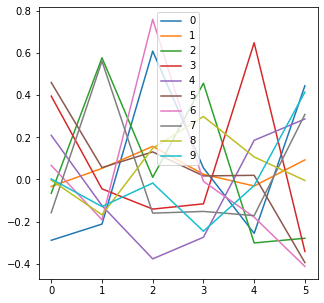

In [8]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

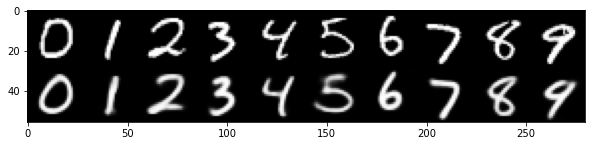

In [9]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [10]:
exn = 5

In [11]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

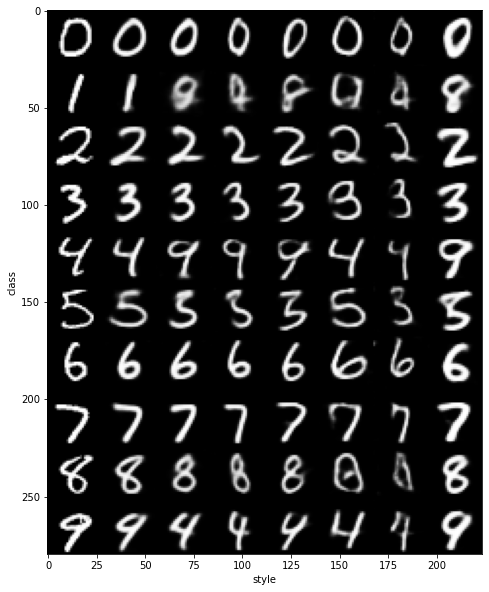

In [12]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [13]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

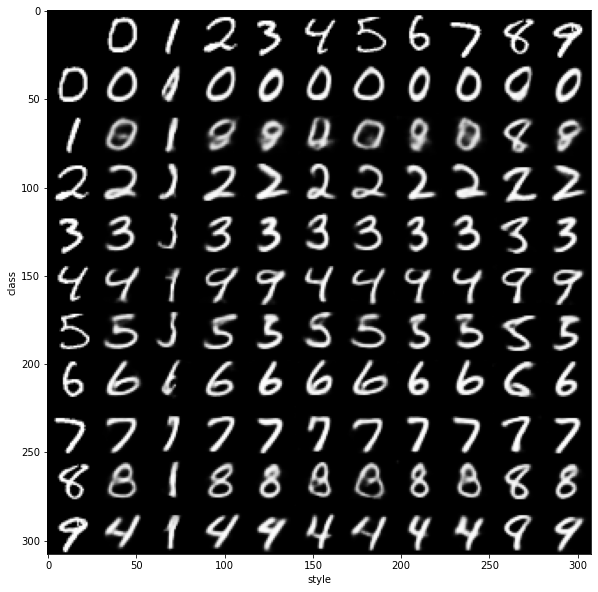

In [14]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()